# Twitter Multithreading  Multi-Network Crawl/Query => Graph

## i. Load & Initialize

In [1]:
#!pip install python-decouple
import json
import re
from collections import Counter
import time


import tweepy
from decouple import config
import pandas as pd

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize

absl-py==0.7.0
alabaster==0.7.11
anaconda-client==1.7.2
anaconda-navigator==1.9.6
anaconda-project==0.8.2
appdirs==1.4.3
appnope==0.1.0
appscript==1.0.1
asn1crypto==0.24.0
astor==0.7.1
astroid==2.0.4
astropy==3.0.4
async-generator==1.10
atomicwrites==1.2.1
attrs==18.2.0
Automat==0.7.0
Babel==2.6.0
backcall==0.1.0
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.6.3
bitarray==0.8.3
bkcharts==0.2
blaze==0.11.3
bleach==2.1.4
bokeh==1.0.4
boto==2.49.0
Bottleneck==1.2.1
CacheControl==0.12.5
cachetools==3.1.0
certifi==2019.3.9
cffi==1.11.5
chardet==3.0.4
click==6.7
cloudpickle==0.5.5
clyent==1.2.2
colorama==0.3.9
conda==4.6.14
conda-build==3.15.1
constantly==15.1.0
contextlib2==0.5.5
cryptography==2.5
cycler==0.10.0
Cython==0.28.5
cytoolz==0.9.0.1
dask==1.1.4
datashape==0.5.4
decorator==4.3.0
defusedxml==0.5.0
distributed==1.26.0
docutils==0.14
entrypoints==0.2.3
enum34==1.1.6
et-xmlfile==1.0.1
fastavro==0.21.19
fastcache==1.0.2
filelock==3.0.8
firebase-admin==2.16.0
Flask==1.0.2


## iii. Set Notebook Parameters

In [2]:
# List of strings = TWITTER_ACCESS_TOKEN', 'TWITTER_ACCESS_TOKEN_SECRET'
twitter_creds = {} 

# interaction_chain parameters
original_user = 'bwinterrose'
search_users = ['austen','paulg','justinkhan','tommycollison',"lambdaschool"] # Error handling for empty.
return_limit = 20 # -1 is no limit, anything above 1 sets limit.
last_level = 2 # Set to number of levels. 

# return parameters
no_of_results = 50 # set to the number of results you want returned.

## ii. Load Twitter Credentials

In [48]:
# if running in colab, upload `.env` as `env` then run:
#!mv env .env

# If twitter_creds are filled
# if not twitter_creds:
#     #Load Twitter Credentials File
#     twitter_auth = tweepy.OAuthHandler(config('TWITTER_CONSUMER_KEY'),config('TWITTER_CONSUMER_SECRET'))
#     twitter_auth.set_access_token(config('TWITTER_ACCESS_TOKEN'),config('TWITTER_ACCESS_TOKEN_SECRET'))
#     TWITTER = tweepy.API(twitter_auth)
# else:

twitter_auth = tweepy.OAuthHandler(config('TWITTER_CONSUMER_KEY'),config('TWITTER_CONSUMER_SECRET'))
access_token = "920935903-asdbKUPkKXPha64fS4jLA3WON9fugD7CcVwFCoki"
access_token_secret = "CioCgHCvIXsoXs9rXn9W8XVu6s5fFPUqLdfoOZTDfPlGt"
twitter_auth.set_access_token(access_token, access_token_secret)
TWITTER = tweepy.API(twitter_auth)

In [51]:
access_token.encode().decode()

'920935903-asdbKUPkKXPha64fS4jLA3WON9fugD7CcVwFCoki'

## 1. Capture current TwiterAPI rate limit status

In [49]:
# Check the limit before running the function, then check again after and compare. 
start_api_check = TWITTER.rate_limit_status()
limits_alpha = json_normalize(start_api_check)

## 2.  Function: Retrieve User Interactions

In [5]:
def get_user_interactions(list_dict):
    """Crawls the targeted user's timeline and returns interactions.
    Args:
        `list_dict`, dict: A dictionary containing the following variables: 
            `search`, string: The name of the user who's timeline to search.
            `output`, list of tuples: paired list of search & interaction targets. 
            `next_query`, list: a list of names to search on the next run. 
            `limit`, int: A flag to indicate how many results should be returned. 
    
    Functionality:
        Initialize search for the specific user.
        Get the user's tweets from their timeline. 
        Cycle through all the tweets' text and join it into a mega-string.
        Do some standardizing and replacing.
        Strip away everything except usernames, into a string. 
        Make a list of the counts, and take the top (X) most common people. 
        Creates a list of the `top` people. No duplicates 
        Tuples the results of the search & output together.
        Make search inputs for the next level of crawling.
    
    Returns:
        This function is async and has no return statement, rather it 
        instead updates the values of `output` and `next_query` extending
        the lists that were passed to it as args.
    """
    search, output, found, limit = list_dict
    try:
        twitter_user = TWITTER.get_user(search)
        tweets = twitter_user.timeline(
                    count=200,
                    exclude_replies=False,
                    include_rts=True,
                    tweet_mode='extended'
        )
        b = [ i.full_text for i in tweets ]
        b = " ".join(b)
        b = b.lower()
        b = b.replace(search, "")
        out = re.findall(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)',b)
        top = Counter(out).most_common(limit)

        if limit > 0:
            interactions = []
            for interaction_count in top:
                interactions += ([interaction_count[0]] * interaction_count[1])

            tweet_data = [(search, i) for i in interactions]
            output.extend(tweet_data)

            found_users = [person[0] for person in top]
            found.extend(found_users)

        elif limit == -1: 
            tweet_data = [(search, i) for i in out]
            output = output.extend(tweet_data)
            
            found_users = [person[0] for person in top]
            found.extend(found_users)
    
    except tweepy.TweepError:
        print("tweepy.TweepError")
        
    except:
        e = sys.exc_info()[0]
        print("Error: %s" % e)

## 2. Multithreaded multi-query using python futures to retrieve data

In [6]:
def interaction_chain(origin_user, search_target_users, return_limit, last_lvl):
    from concurrent.futures import ThreadPoolExecutor as PoolExecutor
    """Calls our async function & loops through it for each target user."""
    
    # init function variables
    data = []
    lvl = 0
    
    start_time = time.time()
    last_time = time.time()
    
    s_users = [] # Passed into the active loops for each level.  
    f_users = search_target_users # Gathered from each loop cycle for the current level. 
    p_users = [] # Current users deposited after llvl, used to clean out next users.
    p_users += origin_user # Add originating username to p_users. 

    # Updates the time for each loop.
    def funct_time(last, d, l):
        now = time.time()
        check_time = now - last
        print("\n\nLevel %s Completed\nLevel %s time to complete: %s." % (l, l, check_time))
        print("Level %s total cumulative interactions found:", (l, len(d)))
        return now
    
    # Dedupe & Check user list for previous runs (no duplicated work). 
    def update_lists(ss_users, ff_users, pp_users, llvl, llst_lvl):
        ff_users = list(dict.fromkeys(ff_users)) # Dedupe f_users. 
        pp_users += ss_users # Deposit last search(ed)_users into p_users. (input to last run)
        for i in pp_users: # Remove p_users from f_users.
            a = np.array(ff_users) 
            a = a[a != i] 
            ff_users = a.tolist() 
        ss_users = ff_users #Overwrite ss_users list with cleaned ff_users loop output. 
        ff_users = [] #Reset ff_users for next run.
        if llvl == 0: # on first run.... 
            llvl += 1 
            print("----------Entering %sst level. Searching the following users:----------\n" % llvl, ss_users)
        else: # on other runs...
            print("Level %s new connections found:" % llvl, len(ss_users), "\n\n")
            print("Total %s connections discovered so far." % (len(pp_users)+len(ss_users)))
            if llvl < llst_lvl:
                llvl += 1
                print("---------Beginning Level %s - Searching the following users:\n" % llvl, ss_users)
        return ss_users, ff_users, pp_users, llvl
    
    # Pre-run print. 
    s_users, f_users, p_users, lvl = update_lists(s_users, f_users, p_users, lvl, last_lvl)  
        
    # Level 1 Run.
    loop_num = 1
    with PoolExecutor(max_workers=20) as executor:
        for _ in executor.map(get_user_interactions, [(x, data, f_users, return_limit) for x in s_users]):
            print("Loop # ", loop_num, " . Time so far:", time.time() - start_time)
            loop_num +=1
            pass
    
    last_time = funct_time(last_time, data, lvl)
    s_users, f_users, p_users, lvl = update_lists(s_users, f_users, p_users, lvl, last_lvl)  


    # Level 2 Run.
    loop_num = 1
    with PoolExecutor(max_workers=20) as executor:
        for _ in executor.map(get_user_interactions, [(x, data, f_users, return_limit) for x in s_users]):
            print("Loop # ", loop_num, " . Time so far:", time.time() - start_time)
            loop_num +=1
            pass

    last_time = funct_time(last_time, data, lvl)
    s_users, f_users, p_users, lvl = update_lists(s_users, f_users, p_users, lvl, last_lvl)  

#     # Level 3 Run.
#     loop_num = 1
#     with PoolExecutor(max_workers=20) as executor:
#         for _ in executor.map(get_user_interactions, [(x, data, f_users, return_limit) for x in s_users]):
#             print("Loop # ", loop_num, " . Time so far:", time.time() - start_time)
#             loop_num +=1
#             pass

#     last_time = funct_time(last_time, data, lvl)
#     s_users, f_users, p_users, lvl = update_lists(s_users, f_users, p_users, lvl, last_lvl)  
    
    print("Total time:", time.time() - start_time)
    print("Total Connections found:", (len(p_users)-1))
    print("Total Overall Interactions found:", len(data))
    no_total_interactions = len(data)
    return data, no_total_interactions

## 3. Call the `multithreaded` function. 
Notice the errors are handeled in the output.

In [7]:
response_data, interactions_found = interaction_chain(original_user, search_users, return_limit, last_level)

----------Entering 1st level. Searching the following users:----------
 ['austen', 'paulg', 'justinkhan', 'tommycollison', 'lambdaschool']
Loop #  1  . Time so far: 2.1011579036712646
Loop #  2  . Time so far: 2.1013262271881104
Loop #  3  . Time so far: 2.1014010906219482
Loop #  4  . Time so far: 2.101473093032837
Loop #  5  . Time so far: 2.10154390335083


Level 1 Completed
Level 1 time to complete: 2.10247802734375.
Level %s total cumulative interactions found: (1, 463)
Level 1 new connections found: 69 


Total 85 connections discovered so far.
---------Beginning Level 2 - Searching the following users:
 ['calebhicks', 'trevmckendrick', 'mitchellbwright', 'ouraring', 'ryanleehamblin', 'mckaywrigley', 'davecraige', 'sunjieming', 'jlhenriod', 'patrickc', 'artirkel', 'jesslivingston', 'mrroryflint', 'gyroscope_app', 'nwthomas_', 'bwinterrose', 'thebigknell', 'kevinsimler', 'amasad', 'esyudkowsky', 'maxcroser', 'gwern', 'stevesi', 'samgichuru', 'tesla', 'webdevmason', 'stephansturges

## 4. Prep the data for conversion into a `networkx MultiDiGraph` object

In [8]:
%%time
# DF before Groupby
df = pd.DataFrame(response_data, columns=['source_user', 'interaction_user'])
display(df.shape)
display(df.head(5))

# Create groupby counts
df_group = df.groupby(['source_user','interaction_user']).size().reset_index().rename(columns={0: "count"})
display(df_group.head())
display(df_group.shape)

# Create "Normalized" interaction weights for each user's interactions. 
a = df_group.groupby('source_user')['count'].transform('sum')
df_group['weight'] = df_group['count'].div(a)
display(df_group.head())
display(df_group.shape)

(8320, 2)

,source_user,interaction_user
0,tommycollison,lambdaschool
1,tommycollison,lambdaschool
2,tommycollison,lambdaschool
3,tommycollison,lambdaschool
4,tommycollison,lambdaschool


,source_user,interaction_user,count
0,a16z,alecstapp,4
1,a16z,ali01,5
2,a16z,andrewchen,8
3,a16z,benedictevans,17
4,a16z,chloecondon,2


(1429, 3)

,source_user,interaction_user,count,weight
0,a16z,alecstapp,4,0.028777
1,a16z,ali01,5,0.035971
2,a16z,andrewchen,8,0.057554
3,a16z,benedictevans,17,0.122302
4,a16z,chloecondon,2,0.014388


(1429, 4)

CPU times: user 46.4 ms, sys: 8.43 ms, total: 54.8 ms
Wall time: 57.5 ms


## 5. Convert the Pandas Dataframe to Networkx Graph

In [9]:
%%time
# Create the directional graph object. (Uses weight or count derived summaries.)
DG = nx.from_pandas_edgelist(df_group, "source_user", "interaction_user",
                            edge_attr=['weight', "count"], 
                             create_using=nx.DiGraph())
found_nodes = nx.number_of_nodes(DG) 
print("total nodes:",nx.number_of_nodes(DG))

total nodes: 1032
CPU times: user 11.5 ms, sys: 2.49 ms, total: 14 ms
Wall time: 14.6 ms


In [10]:
# %%time
# # Create the multiconnected directional graph object. (no weights/counts)
# MDG = nx.from_pandas_edgelist(df_group, "source_user", "interaction_user",
#                              create_using=nx.MultiDiGraph())
# found_nodes = nx.number_of_nodes(MDG) 
# print("total nodes", nx.number_of_nodes(MDG))

## 6. Apply NetworkX PageRank and return rank sorted dataframe

In [11]:
%%time
# DiGraph w/ Normalized Weighting version
pr = nx.pagerank_numpy(DG, alpha= 0.85, weight="weight") # Pagerank it!
dg_pr_df = pd.DataFrame([pr]).T.reset_index() 
dg_pr_df = dg_pr_df.rename(index=str, columns={"index": "username", 0: "pagerank"})
dg_pr_df.sort_values(by=['pagerank'], ascending=False, inplace = True)
display(dg_pr_df.head(10))

,username,pagerank
85,austen,0.009399
541,lambdaschool,0.009158
711,paulg,0.002550
957,tommycollison,0.002196
86,austenallred,0.002005
159,career_karma,0.001823
613,mckaywrigley,0.001741
281,elonmusk,0.001630
371,honestduane,0.001574
586,mandalane_,0.001507


CPU times: user 2.85 s, sys: 201 ms, total: 3.05 s
Wall time: 1.01 s


In [12]:
# %%time
# MultiDiGraph w/ raw interaction count based weighting. 
# m_pr = nx.pagerank_numpy(MDG, alpha=0.85) # Pagerank it! 
# mdg_pr_df = pd.DataFrame([m_pr]).T.reset_index()
# mdg_pr_df = mdg_pr_df.rename(index=str, columns={"index": "username", 0: "pagerank"})
# mdg_pr_df = mdg_pr_df.sort_values(by=['pagerank'], ascending=False).reset_index(drop=True)
# display(mdg_pr_df.head(10))

## 8. Query TwitterAPI and Inspect Rate Usage

In [13]:
# Query API 
end_api_check = TWITTER.rate_limit_status()
limits_beta = json_normalize(end_api_check).T
limits_beta.rename(columns = {0:'beta',}, inplace = True)

# Compare the change of ALL API ENDPOINTS between limits, alpha (before run), and beta (after run.)
limits_delta = limits_alpha.T.copy()
limits_delta['beta'] = limits_beta['beta']
limits_delta = limits_delta.reset_index(drop=False)
limits_delta.rename(columns = {0:'alpha', 'index':'api_endpoint'}, inplace = True)
limits_delta = limits_delta[['api_endpoint','alpha', 'beta']].assign(delta=limits_delta.alpha != limits_delta.beta)
limits_delta['type'] = limits_delta.api_endpoint.str.split(pat = '.', n = 1, expand = True)[0]
limits_delta['sub_type'] = limits_delta.api_endpoint.str.split(pat = '.', n = 2, expand = True)[1]
limits_delta['api_path'] = limits_delta.api_endpoint.str.split(pat = '.', n = 2, expand = True)[2].str.rsplit(pat = '.', n = 1, expand = True)[0]
limits_delta['method'] = limits_delta.api_path.str.rsplit(pat = '/', n = 1, expand = True)[1]
limits_delta['stat'] = limits_delta.api_endpoint.str.rsplit(pat = '.', n = 1, expand = True)[1]
limits_delta['alpha'] = pd.to_numeric(limits_delta["alpha"], errors='coerce')
limits_delta['beta'] = pd.to_numeric(limits_delta["beta"], errors='coerce')
limits_delta = limits_delta[['type', 'sub_type', 'api_path', 'method', 'stat', 'alpha', 'beta', 'delta']]
limits_delta["amt_used"] = limits_delta["alpha"] - limits_delta["beta"]

# Filter Dataframe
api_usage = limits_delta[(limits_delta['stat'].str.contains("reset") == False) & (limits_delta['delta']==True)]
api_usage = api_usage[["sub_type", "api_path", "alpha", "beta", "amt_used"]].copy()
api_usage.rename(columns = {"sub_type": "type", 'alpha': "before_query", 'beta':'after_query'}, inplace = True)
api_usage = api_usage.set_index('type')
api_usage = api_usage.to_dict('index')

,type,sub_type,api_path,method,stat,alpha,beta,delta,amt_used


In [14]:
api_usage = api_usage[["sub_type", "api_path", "alpha", "beta", "amt_used"]].copy()
api_usage.rename(columns = {"sub_type": "type", 'alpha': "before_query", 'beta':'after_query'}, inplace = True)
api_usage = api_usage.set_index('type')
api_used = api_usage.to_dict('index')

In [15]:
api_used

{}

## 7. Return Pagerank results as JSON

In [20]:
def return_json(pageranked_df, origin_user, search_target_users, qty_users_found, qty_interactions_found, api_use):
    ranked_dict = pageranked_df[["username"]].head(no_of_results).username.tolist()
    #search_dict = {("search_user_%s" % i) : search_target_users[i] for i in range(0, len(search_target_users))}
    final_dict = {"original_user" : original_user, 
                  "search_users" : search_target_users, 
                  "network_size": qty_users_found,
                  "interactions_found" : qty_interactions_found, 
                  "ranked_results": ranked_dict, 
                  "api_usage": api_used}
    final_json = json.dumps(final_dict)
    return final_json # Returns JSON string. 

return_json(dg_pr_df, original_user, search_users, found_nodes, interactions_found)

'{"origin_user": "bwinterrose", "search_users": ["austen", "paulg", "justinkhan", "tommycollison", "lambdaschool"], "network_size": 1032, "interactions_found": 8320, "ranked_results": ["austen", "lambdaschool", "paulg", "tommycollison", "austenallred", "career_karma", "mckaywrigley", "elonmusk", "honestduane", "mandalane_", "rubenharris", "stevenglinert", "kevinsimler", "calebhicks", "timurmeyster", "ryanallred", "a16z", "bri_theengineer", "benedictevans", "trevmckendrick", "kailavansumer", "nwthomas_", "amasad", "pioneerdotapp", "dustint314", "noahpinion", "ryanleehamblin", "spakhm", "shl", "robinhanson", "webdevmason", "jasonsbarr", "hashim_warren", "stevesi", "withfries2", "replit", "atbenedict", "flatironschool", "balajis", "reactjs", "dan_abramov", "zimvc", "danielgross", "mispelledtoyota", "thebigknell", "tavachristian", "ne0liberal", "kevinakwok", "garrytan", "flexport"], "api_usage": {}}'

## X. Graph the Networkx graph objects. 

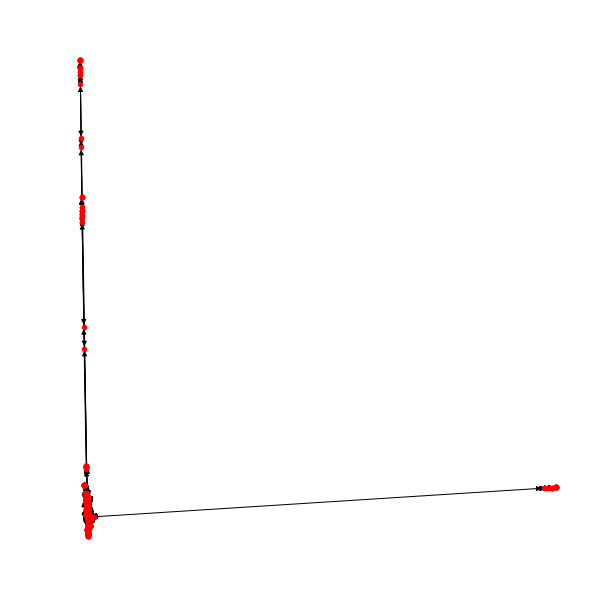

CPU times: user 4.85 s, sys: 214 ms, total: 5.07 s
Wall time: 4.72 s


In [17]:
%%time
fig = plt.figure(figsize=(8,8))
nx.draw_spectral(DG, node_size=20)
plt.show()

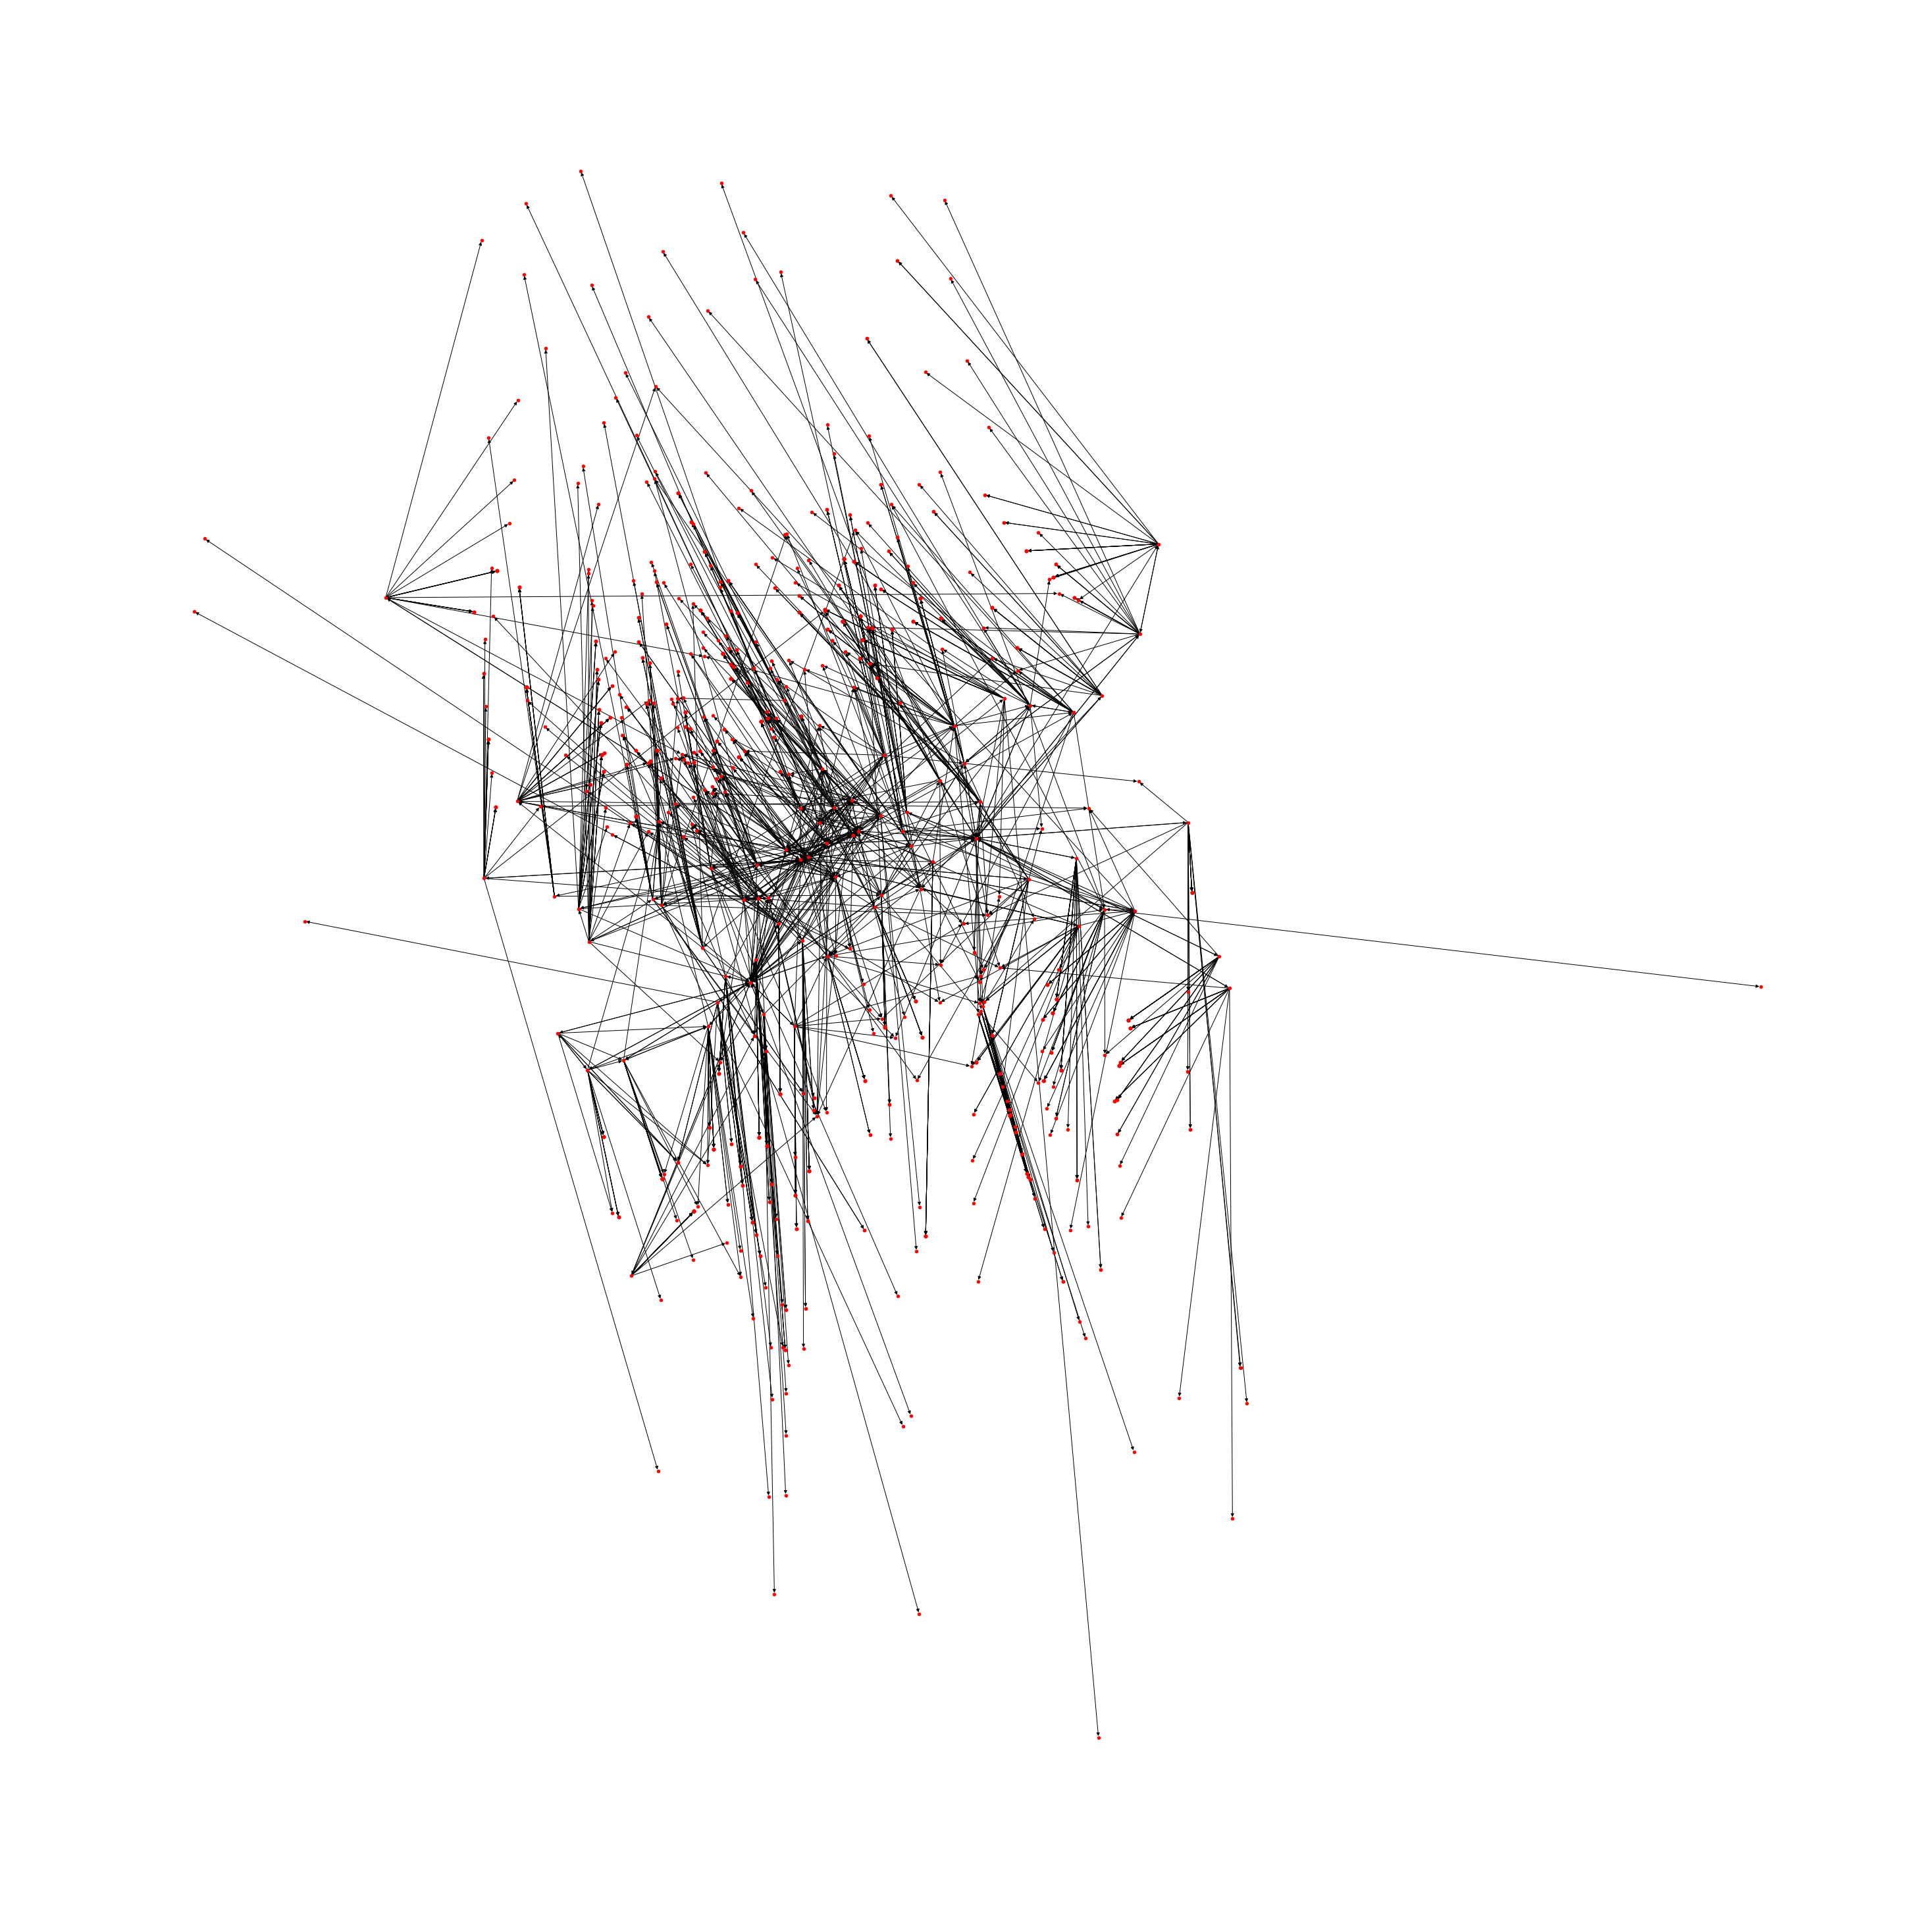

CPU times: user 49.9 s, sys: 4.94 s, total: 54.9 s
Wall time: 58.8 s


In [18]:
%%time
fig = plt.figure(figsize=(40,40))
nx.draw_kamada_kawai(DG,node_size=20)
plt.show()
# Use kamada_kawai_layout for creating the graph.

## Generate Example POST request JSON

In [28]:
# Generate example POST request
example_post = json.dumps({"origin_user" : original_user,
                  'TWITTER_ACCESS_TOKEN' : config('TWITTER_ACCESS_TOKEN'),
                  'TWITTER_ACCESS_TOKEN_SECRET' : config('TWITTER_ACCESS_TOKEN_SECRET'),
                  "search_users" : search_users, 
                  "return_limit": return_limit})

In [29]:
example_post

'{"origin_user": "bwinterrose", "TWITTER_ACCESS_TOKEN": "920935903-asdbKUPkKXPha64fS4jLA3WON9fugD7CcVwFCoki", "TWITTER_ACCESS_TOKEN_SECRET": "CioCgHCvIXsoXs9rXn9W8XVu6s5fFPUqLdfoOZTDfPlGt", "search_users": ["austen", "paulg", "justinkhan", "tommycollison", "lambdaschool"], "return_limit": 20}'